
Machine Learning on Big Data (CN7030) CRWK 21-22 [60 marks]
Group ID: 5
Student 1: MARIA ANTONY and 2176663
Student 2: PARDHA SARADHI GUNDLAPLLI and 2176298


Module leader: Dr Amin Karami (a.karami@uel.ac.uk)
If you want to add comments on your group work, please write it here for us:

In [ ]:
# # Checking PYSPARK Directory
import findspark
findspark.init()

In [2]:
# Configuration PYSPARK 
# This is the configuration of pyspark application. Here various parameters are set as key-value pairs.
# Configuration PYSPARK 
from pyspark.sql import SparkContext, SparkConf
spark = SparkContext(master='local[2]',appName = "ML_BIGDATA")

In [41]:
# Importing Packages / Libraries
from pyspark.sql.functions import regexp_replace, col
from pyspark.sql.types import IntegerType
from pyspark.ml.feature import StringIndexer, VectorAssembler,PCA
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from pyspark.ml.tuning import ParamGridBuilder,CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator,MulticlassClassificationEvaluator
from sklearn.metrics import *
from sklearn.metrics import confusion_matrix, classification_report,ConfusionMatrixDisplay
from pyspark.ml.feature import StandardScaler
import matplotlib.pyplot as plt
import warnings
import scikitplot as skplt
warnings.filterwarnings("ignore")

In [5]:
# Data Reading and Updating Columns
# Here we load the data and re-named all the columns. It is then saved back to df.
df = spark.read.csv('UNSW-NB15.csv',inferSchema=True, header =False)
updated_col_names = [
       'srcip','sport','dstip','dsport','proto','state','dur','sbytes','dbytes','sttl','dttl','sloss','dloss','service','Sload',
       'Dload','Spkts','Dpkts','swin','dwin','stcpb','dtcpb','smeansz','dmeansz','trans_depth','res_bdy_len','Sjit','Djit','Stime','Ltime','Sintpkt',
       'Dintpkt','tcprtt','synack','ackdat','is_sm_ips_ports','ct_state_ttl','ct_flw_http_mthd','is_ftp_login','ct_ftp_cmd',
       'ct_srv_src','ct_srv_dst','ct_dst_ltm','ct_src_ ltm','ct_src_dport_ltm','ct_dst_sport_ltm','ct_dst_src_ltm','attack_cat','Label'
]
df = df.toDF(*updated_col_names)

# Data Engineering & Feature Engineering

    * Through data dngineering, we collect,translate and validate data for analysis
    * Using feature engineering techniques, we choose, manipulate and convert raw data into features. It is used in         Supervised Learning. It simplifies and speed up data transformations. Also, improving model accuracy.

***Dropping Un-Wanted Columns***

In [6]:
# Dropping un-wanted columns- There are several un-wanted columns which are not required for classification. Removing such columns helps to improve the performance and helps to get good accuracy. 
# Selected relevant features based on domain importance
df_1 = df.drop("srcip","sport","dstip","dsport","swin","dwin","stcpb","dtcpb","Stime","Ltime","Label")
# view data
df_1.show(3)

+-----+-----+-----------+------+------+----+----+-----+-----+-------+---------+---------+-----+-----+-------+-------+-----------+-----------+---------+---------+---------+----------+------------+------------+-------+---------------+------------+----------------+------------+----------+----------+----------+----------+-----------+----------------+----------------+--------------+----------+
|proto|state|        dur|sbytes|dbytes|sttl|dttl|sloss|dloss|service|    Sload|    Dload|Spkts|Dpkts|smeansz|dmeansz|trans_depth|res_bdy_len|     Sjit|     Djit|  Sintpkt|   Dintpkt|      tcprtt|      synack| ackdat|is_sm_ips_ports|ct_state_ttl|ct_flw_http_mthd|is_ftp_login|ct_ftp_cmd|ct_srv_src|ct_srv_dst|ct_dst_ltm|ct_src_ ltm|ct_src_dport_ltm|ct_dst_sport_ltm|ct_dst_src_ltm|attack_cat|
+-----+-----+-----------+------+------+----+----+-----+-----+-------+---------+---------+-----+-----+-------+-------+-----------+-----------+---------+---------+---------+----------+------------+------------+-------+

Checking for special characters using group by techniques and replacing with 
    For categorical: Mode
    For Numerical: Mean / Median

In [7]:
# This helps to find the most frequent value from the column 'service'. Also, getting the count in ascending order.
df_1.groupBy("service").count().orderBy("count",ascending=True).show()

# As there is more number of '-', we replace it with no_frequent. Replacing with no_frequent using regexp_replace.
df_1 = df_1.withColumn("service_new",regexp_replace(col("service"),"-","no_frequent"))

#Inorder to cross check, we selcet both 'service' and 'service_new', then showed.
df_1.select('service','service_new').show()

# Dropping service form data as it is not required.
df_1 = df_1.drop("service")

+--------+-------+
| service|  count|
+--------+-------+
|     irc|     31|
|  radius|     40|
|    snmp|    113|
|     ssl|    142|
|    dhcp|    172|
|    pop3|   1533|
|     ssh|  47160|
|     ftp|  49090|
|    smtp|  81645|
|ftp-data| 125783|
|    http| 206273|
|     dns| 781668|
|       -|1246089|
+--------+-------+

+--------+------------------+
| service|       service_new|
+--------+------------------+
|       -|       no_frequent|
|       -|       no_frequent|
|       -|       no_frequent|
|       -|       no_frequent|
|       -|       no_frequent|
|       -|       no_frequent|
|     dns|               dns|
|ftp-data|ftpno_frequentdata|
|     dns|               dns|
|     dns|               dns|
|     dns|               dns|
|ftp-data|ftpno_frequentdata|
|       -|       no_frequent|
|       -|       no_frequent|
|       -|       no_frequent|
|     dns|               dns|
|     dns|               dns|
|     dns|               dns|
|     ftp|               ftp|
|       -|      

Target variable(attack_cat) contains null valaues and treating it as no attack as per documentation given(1-attack, 0-normal)

In [8]:
# Filling na as normal using na.fill method
df_1 = df_1.na.fill(value="normal",subset=["attack_cat"])
# Showing results lable wise
df_1.groupBy("attack_cat").count().show()

+---------------+-------+
|     attack_cat|  count|
+---------------+-------+
|          Worms|    174|
|         normal|2218456|
|       Analysis|   2677|
|     Shellcode |   1288|
|            DoS|  16353|
|Reconnaissance |  12228|
|       Backdoor|   1795|
|       Fuzzers |  19195|
|       Exploits|  44525|
|        Generic| 215481|
|      Shellcode|    223|
|      Backdoors|    534|
|        Fuzzers|   5051|
| Reconnaissance|   1759|
+---------------+-------+



from target variable, few lables are same but because of spaces those are being treated as different labels

  For example: label Reconnaissance repeated two times with spaces

  Using **regexp_replace** function strimming spaces from labels

In [9]:
# From attack_cat, we replace space and updated it to without any space. So the space from previous section is removed and it becomes Reconnaissance(count= 13987).
df_1 = df_1.withColumn("attack_cat",regexp_replace(col("attack_cat")," ",""))
# cross-checking - Here we cross-check that using groupby and the count is shown in ascending order.
df_1.groupBy("attack_cat").count().orderBy("count",ascending=True).show()

+--------------+-------+
|    attack_cat|  count|
+--------------+-------+
|         Worms|    174|
|     Backdoors|    534|
|     Shellcode|   1511|
|      Backdoor|   1795|
|      Analysis|   2677|
|Reconnaissance|  13987|
|           DoS|  16353|
|       Fuzzers|  24246|
|      Exploits|  44525|
|       Generic| 215481|
|        normal|2218456|
+--------------+-------+



***Feature Engineering - Variable Encoding***

    * Here we convert categorical variables to numeric variables.

Replacing target variables with custom keys

In [10]:
# Only for Target Variable Custom Encoding
# Here we replace the target variables with custom keys. Value is given for each variable. 
#It is then converted into IntegerType and the result is shown.
target_key_pair = {"normal":'0',"Generic":'1',"Exploits":'2',"Fuzzers":'3',"DoS":'4',
                        "Reconnaissance":'5',"Analysis":'6',"Backdoor":'7',
                          "Shellcode":'8',"Backdoors":'9',"Worms":'10'}

df_1 = df_1.replace(to_replace=target_key_pair,subset=['attack_cat'])
df_1= df_1.withColumn("attack_cat",col("attack_cat").cast(IntegerType()))
df_1.select('attack_cat').show(3)

+----------+
|attack_cat|
+----------+
|         0|
|         0|
|         0|
+----------+
only showing top 3 rows



In [11]:
# Vector Indexing
# By using StringIndexer we convert string data into numerical, then we perform fit and transform in df_1.
df_1 = StringIndexer(inputCol="state",outputCol="state_1").fit(df_1).transform(df_1)
df_1 = StringIndexer(inputCol="service_new",outputCol="service_new_1").fit(df_1).transform(df_1)

In [12]:
# We drop string columns and keeping the numerical columns.
#Then the result is shown.
df_1 = df_1.drop("proto","state","service_new")
df_1.show(2)

+----------+------+------+----+----+-----+-----+---------+---------+-----+-----+-------+-------+-----------+-----------+---------+---------+---------+--------+------------+------------+-------+---------------+------------+----------------+------------+----------+----------+----------+----------+-----------+----------------+----------------+--------------+----------+-------+-------------+
|       dur|sbytes|dbytes|sttl|dttl|sloss|dloss|    Sload|    Dload|Spkts|Dpkts|smeansz|dmeansz|trans_depth|res_bdy_len|     Sjit|     Djit|  Sintpkt| Dintpkt|      tcprtt|      synack| ackdat|is_sm_ips_ports|ct_state_ttl|ct_flw_http_mthd|is_ftp_login|ct_ftp_cmd|ct_srv_src|ct_srv_dst|ct_dst_ltm|ct_src_ ltm|ct_src_dport_ltm|ct_dst_sport_ltm|ct_dst_src_ltm|attack_cat|state_1|service_new_1|
+----------+------+------+----+----+-----+-----+---------+---------+-----+-----+-------+-------+-----------+-----------+---------+---------+---------+--------+------------+------------+-------+---------------+---------

In [13]:
# Getting all the input columns except target column and saving it to input_col
input_col = [col for col in df_1.columns if col != "attack_cat"]
# vector assembler 1 D vector
# By using VecorAssembler, we convert the input columns into vector form and then it is transformed in df_1. From the assembler, it then selects "attack_cat" and "features"
assembler = VectorAssembler(inputCols=input_col,outputCol="features").transform(df_1)
model_data = assembler.select("attack_cat","features")

***Standard Scaler***

    * Standard Scaler fits into the dataset to produce Standard Scaler Model. The vector column in the dataset is then transformed to have unit standard deviation or zero mean characteristics. 

In [ ]:
# Scaling the Data
# Using StandardScaler, we perform scaling. Input column is given as features and the output column as scaled_features.
# Fit and transform is performed in model_data and the table is shown.
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")
scaler_model = scaler.fit(model_data) # Fitting
scaled_data = scaler_model.transform(model_data) # Transforming
scaled_data.show(3)

+----------+--------------------+--------------------+
|attack_cat|            features|     scaled_features|
+----------+--------------------+--------------------+
|         0|[0.82546002,7812....|[0.05927572840054...|
|         0|[0.101815,4238.0,...|[0.00731126661604...|
|         0|[0.044002999,2750...|[0.00315982573878...|
+----------+--------------------+--------------------+
only showing top 3 rows



***Principal Component Analysis***

    *This is a dimensionality reduction technique. It trains the model to project vectors to low dimensional space of top k components. dimensional space of top k components.

In [ ]:
# Scaling the Data, take top 4 components. InputCol is given as scaled_features and outputCol is given as pcaFeatures.
# Fit and transform is done on scaled_data and then showing the result.

pca = PCA(k=4, inputCol="scaled_features", outputCol="pcaFeatures")
pca_model = pca.fit(scaled_data) # Fitting
pca_data = pca_model.transform(scaled_data) # Transforming
pca_data.show(3)

+----------+--------------------+--------------------+--------------------+
|attack_cat|            features|     scaled_features|         pcaFeatures|
+----------+--------------------+--------------------+--------------------+
|         0|[0.82546002,7812....|[0.05927572840054...|[-0.0235286606229...|
|         0|[0.101815,4238.0,...|[0.00731126661604...|[-0.2517619839385...|
|         0|[0.044002999,2750...|[0.00315982573878...|[-0.0993967950510...|
+----------+--------------------+--------------------+--------------------+
only showing top 3 rows



In [18]:
# Data Spliting for Model Building
# 70% data for training and 30% data for testing
train, test = pca_data.randomSplit([0.7,0.3])


# **Task 1 - Binary Classifier [20 marks]**

    * Binary classification is the process of categorising items into two categories based on a classification rule. It is a supervised learning strategy. In this case, computer software learns from data and creates new classifications. Logistic Regression is easier to implement than other methods.


**LOGISTIC REGRESSION - CLASSIFICATION**

In [21]:
# Model Initialization
LR = LogisticRegression()

In [ ]:
# Hyperparameters Defining
# It follows Gridsearch method. It sets the given parameter in the grid to fixed values.It randomly select the values and check for he best outcome.
param_grid = ParamGridBuilder().\
    addGrid(LR.regParam, [0.01, 0.1, 0.5, 1.0]).\ # It should be >0 , so here it will take default coefficiant values
    addGrid(LR.elasticNetParam, [0.0, 0.25, 0.5, 0.75, 1.0]).\ # it is regulizaton(to avoid overfitting issues)
    addGrid(LR.maxIter, [10, 20, 50]).\ # It is the number of iterations.
    build()

In [ ]:
# Evaluate model
# Create 5-fold CrossValidator
# It uses different portion of the data to train and test a model in different iteration.
# Here labelCol is given as attack_cat and featurescol as pcaFeatures, param_grid is given as the input to estimatorParamMaps
# MulticlassClassification evaluator is and the labelcol is set as attack_cat
# first five for testing and remaing training data 
lrcv = CrossValidator(estimator = LogisticRegression(labelCol="attack_cat",featuresCol="pcaFeatures"),
                    estimatorParamMaps = param_grid,
                    evaluator = MulticlassClassificationEvaluator().setLabelCol('attack_cat'),
                    numFolds = 5)

In [22]:
# Model Fitting using train data
LR_Model = LR.fit(train)


# **Task 2 - Multi Classifier [25 marks]**


**Random Forest Classifier  - CLASSIFICATION**

In [ ]:
# Model Initialization - Random Forest Classifier
RF = RandomForestClassifier()

In [ ]:
# Hyperparameters Defining - Random Forest Classifier
# It contains bagging and boosting technique
# It is more accurate and robust
# Here it follows grid search technique where is contains number of trees, impurities and max depth as the parameters.
# gini index takes the values between 0 and 0.5, entropy takes the value between 0 and 1
# It randomly takes the value between these and check for the best outcome

RF_param_grid = ParamGridBuilder().\
    addGrid(RF.numTrees, [10,20,30,40,50]).\
    addGrid(RF.impurity, ['gini','entropy']).\ 
    addGrid(RF.maxDepth, [1, 5, 10, 20, 50]).\
    build()

In [ ]:
# Evaluate model
# Create 5-fold CrossValidator
# Here attack_cat is given as the input in label column and pcaFeatures is given as the input in featuresCol
# RF_param_grid is given to the estimatorParamMaps
# Here multiclassClassification evaluator is used and the label column is set as attack_cat
# Here first five is used for testing and rest for training
RF_cv = CrossValidator(estimator = RandomForestClassifier(labelCol="attack_cat",featuresCol="pcaFeatures"),
                    estimatorParamMaps = RF_param_grid,
                    evaluator = MulticlassClassificationEvaluator().setLabelCol('attack_cat'),
                    numFolds =5)

In [ ]:
# Model Fitting - Random Forest Classifier
# Train data is used for fitting
RFModel = RF.fit(train)


# **Task 3 - Performance Measurements [15 marks]**


***Methods to select evaluate models:***

    * Accuracy
    * Confusion Matrix
    * Classification Report
    * AUC & ROC

In [36]:
# Validating Model & Predicting on Test Data
# Both the model is transformed using test data
LR_pred = LR_Model.transform(test)
RF_pred = RFModel.transform(test)

In [37]:
# Actual vs Predicted Values
# Here we take actual values, predicted values for logistic regression and randon forest prediction
LR_y_hat = LR_pred.select('prediction').collect() # Logistic Prediction
RF_y_hat = RF_pred.select('prediction').collect() # Random Forest Prediction
y_act = LR_pred.select("attack_cat").collect() # Actual Values

***Logistic Regression - Confusion Matrix & Classification Report***

In [ ]:
# Confusion Matrix - Logistic Regression
# Here actual value and predicted value is given as the input to the confusion matrix of logistic regression
LR_confu = confusion_matrix(y_act,LR_y_hat)
# Classification Report - Logistic Regression
# It gives tabular summary of precision, recall, F1 Score, and support of your trained classification model.
LR_class_report = classification_report(y_act,LR_y_hat)

In [ ]:
# Display Confusion Matrix - Logistic Regression
LR_disp = ConfusionMatrixDisplay(confusion_matrix=LR_confu,display_labels=['Normal',
                        'Generic','Exploits','Fuzzers','DoS','Reconnaissance',
                        'Analysis','Backdoor','Shellcode','Backdoors','Worms'])

Logistic Regression Evaluation Metrics:

Cofusion Matrix:




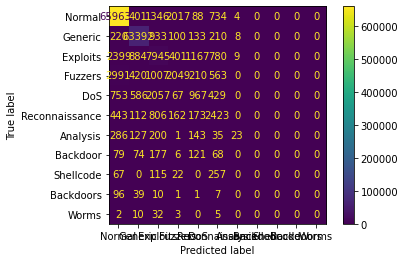

<Figure size 36000x72000 with 0 Axes>



Classification Report:


              precision    recall  f1-score   support

           0       0.99      0.99      0.99    664228
           1       0.96      0.98      0.97     64996
           2       0.54      0.58      0.56     13585
           3       0.42      0.28      0.34      7240
           4       0.32      0.20      0.25      4859
           5       0.44      0.59      0.50      4119
           6       0.52      0.03      0.05       815
           7       0.00      0.00      0.00       525
           8       0.00      0.00      0.00       461
           9       0.00      0.00      0.00       154
          10       0.00      0.00      0.00        52

    accuracy                           0.97    761034
   macro avg       0.38      0.33      0.33    761034
weighted avg       0.96      0.97      0.97    761034



In [ ]:
print("Logistic Regression Evaluation Metrics:\n")
print("Cofusion Matrix:\n\n")
# Plotting Confusion Matrix
LR_disp.plot()
plt.figure(figsize=(500,1000))
plt.show()
# Printing Classification Report
print("\n")
print("Classification Report:\n\n")
print(LR_class_report)

***Random Forest Classifier - Confusion Matrix & Classification Report***

In [ ]:
# Confusion Matrix - Random Forest Classifier
# Here actual value and predicted value is given as the input to the confusion matrix in random forest classifier.
RF_confu = confusion_matrix(y_act,RF_y_hat)
# Classification Report - Random Forest Classifier
RF_class_report = classification_report(y_act,RF_y_hat)

In [ ]:
# Display Confusion Matrix - Random Forest Classifier
RF_disp = ConfusionMatrixDisplay(confusion_matrix=RF_confu,display_labels=['Normal',
                        'Generic','Exploits','Fuzzers','DoS','Reconnaissance',
                        'Analysis','Backdoor','Shellcode','Backdoors','Worms'])

Random Forest Classifier Evaluation Metrics:

Cofusion Matrix:




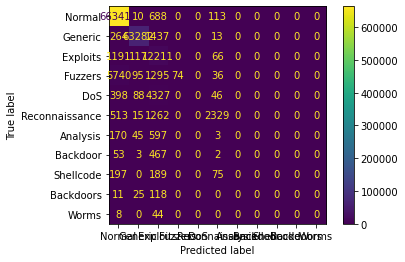

<Figure size 36000x72000 with 0 Axes>



Classification Report:


              precision    recall  f1-score   support

           0       0.99      1.00      0.99    664228
           1       0.99      0.97      0.98     64996
           2       0.54      0.90      0.67     13585
           3       1.00      0.01      0.02      7240
           4       0.00      0.00      0.00      4859
           5       0.87      0.57      0.68      4119
           6       0.00      0.00      0.00       815
           7       0.00      0.00      0.00       525
           8       0.00      0.00      0.00       461
           9       0.00      0.00      0.00       154
          10       0.00      0.00      0.00        52

    accuracy                           0.97    761034
   macro avg       0.40      0.31      0.31    761034
weighted avg       0.97      0.97      0.97    761034



In [ ]:
print("Random Forest Classifier Evaluation Metrics:\n")
print("Cofusion Matrix:\n\n")
# Plotting Confusion Matrix
RF_disp.plot()
plt.figure(figsize=(500,1000))
plt.show()
# Printing Classification Report
print("\n")
print("Classification Report:\n\n")
print(RF_class_report)

***Logistic Regression - AUC & ROC***

No handles with labels found to put in legend.


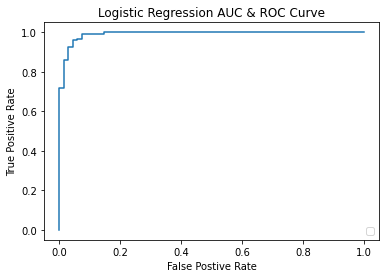

In [51]:
fpr, tpr, _ = metrics.roc_curve(y_act,  LR_y_hat)
auc = metrics.roc_auc_score(y_act, LR_y_hat)
plt.plot(fpr,tpr)
plt.title("Logistic Regression AUC & ROC Curve")
plt.xlabel("False Postive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc=4)
plt.show()

***Random Forest Classifier - AUC & ROC***

No handles with labels found to put in legend.


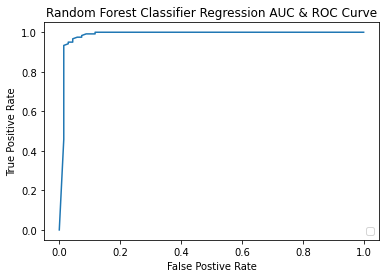

In [54]:
fpr, tpr, _ = metrics.roc_curve(y_act,  RF_y_hat)
auc = metrics.roc_auc_score(y_act, RF_y_hat)
plt.plot(fpr,tpr)
plt.title("Random Forest Classifier AUC & ROC Curve")
plt.xlabel("False Postive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc=4)
plt.show()

***Accuracy Comparision***

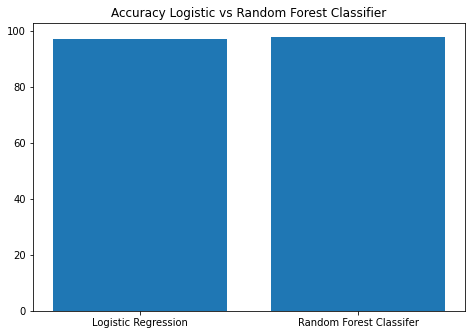

In [32]:
models = ["Logistic Regression","Random Forest Classifier"]
accuracy = [97, 98]
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(models,accuracy)
plt.title("Accuracy: Logistic vs Random Forest Classifier")
plt.show()

***Precison Comparision***

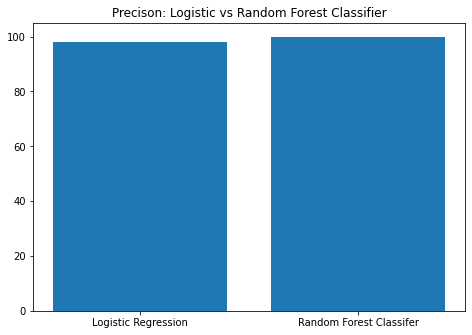

In [34]:
models = ["Logistic Regression","Random Forest Classifier"]
precison = [98, 100]
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(models,precison)
plt.title("Precison: Logistic vs Random Forest Classifier")
plt.show()

***Reacall Comparision***

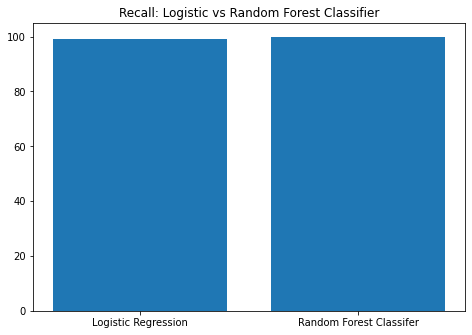

In [35]:
models = ["Logistic Regression","Random Forest Classifier"]
recall = [99,100]
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(models,recall)
plt.title("Recall: Logistic vs Random Forest Classifier")
plt.show()

### Random Forest Classifier Performed Well with 97% Accuracy with High Precision & Recall compared to Logistic regression.